In [43]:
# Imports (if running in JupyterLite this might take a while)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from scipy.integrate import odeint

In [44]:
print("Enter ideas. You can enter them one-by-one, or enter them all at once, separated with a newline.")
ideas = []
answer = "exit"
while answer != "exit":
    answer = input()
    ideas.extend([idea for idea in answer.split('\n') if idea.strip() and idea != "exit"])

print(ideas)

Enter ideas. You can enter them one-by-one, or enter them all at once, separated with a newline.
[]


In [45]:
# Initialize CountVectorizer to convert text into numerical vectors
count_vectorizer = CountVectorizer()

# Fit and transform the text data to numerical vectors
idea_matrix = count_vectorizer.fit_transform(ideas)

# Convert the idea matrix to a numpy array for easier calculations
idea_array = idea_matrix.toarray()

# Calculate the centroid (mean) of the idea array along axis 0 (rows)
centroid = np.mean(idea_array, axis=0)
print('Centroid: ', centroid)

# Calculate cosine similarity between each idea and the centroid
cos_similarity = cosine_similarity(idea_array, centroid.reshape(1, -1))
print('Cosine similarity: ', cos_similarity)

pairwise_similarity = cosine_similarity(idea_matrix, idea_matrix)
print('Pairwise similarity: ')
for row in pairwise_similarity:
    print(row)

with open('pairwise.txt', 'w') as file:
    # Write the distance matrix to the file
    file.write('\nDistance Matrix:\n')
    for row in pairwise_similarity:
        file.write(', '.join(map(str, row)) + '\n')


# make it so that 0 is 'same' and 1 is very different:
distance_to_centroid = 1 - cos_similarity
print('Distance to centroid: (-1 * x)', distance_to_centroid)

# Create an object with the similarity scores for each idea
ideas_and_similarities = [{"idea": ideas[i], "dist": distance_to_centroid[i][0]} for i in range(len(ideas))]
pairwise_distance = pairwise_distances(idea_array, metric='cosine')


Centroid:  [0.04166667 0.04166667 0.04166667 0.25       0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.08333333 0.04166667 0.08333333 0.125      0.04166667 0.54166667
 0.04166667 0.04166667 0.04166667 0.25       0.08333333 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.16666667
 0.08333333 0.08333333 0.04166667 0.04166667 0.04166667 0.08333333
 0.04166667 0.04166667 0.04166667 0.16666667 0.125      0.04166667
 0.08333333 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.08333333 0.04166667 0.04166667 0.08333333
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.08333333
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.16666667 0.08333333 0.04166667 0.04166667 0.04166667 0.125
 0.04166667 0.29166667 0.04166667 0.04166667 0.04166667 0.04166667
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.08333333
 0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 

### MDS MultiDimensional Scaling
Not quite working yet, but might be a good way if we can transform the data properly.

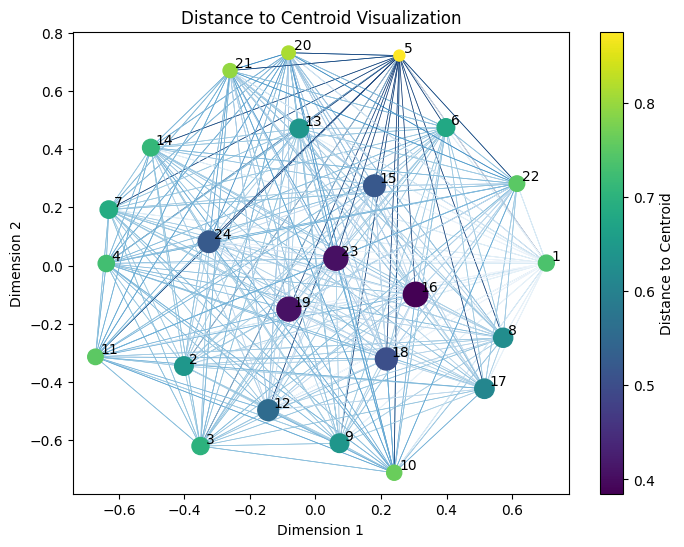

In [61]:
# Center the data
mds = manifold.MDS(n_components=2, dissimilarity='precomputed')

coords = mds.fit_transform(pairwise_distance)
fig, ax = plt.subplots(figsize=(8, 6))

# Normalize the distance_to_centroid array for marker size scaling
marker_sizes = (1 - distance_to_centroid) * 500  # Adjust the scaling factor as needed

scatter = ax.scatter(coords[:, 0], coords[:, 1], c=distance_to_centroid, cmap='viridis', s=marker_sizes)

##### Connection Lines

# Thicker connection lines if points are close to each other
EPSILON = np.finfo(np.float32).eps
line_weights = cos_similarity.max() / (cos_similarity + EPSILON) * 100
np.fill_diagonal(line_weights, 0)

# Plot the edges
start_idx, end_idx = np.where(coords)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [
    [coords[i, :], coords[j, :]] for i in range(len(coords)) for j in range(len(coords))
]
values = np.abs(line_weights)
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.Blues, norm=plt.Normalize(0, values.max())
)
lc.set_array(line_weights.flatten())
lc.set_linewidths(np.full(len(segments), 0.5))
ax.add_collection(lc)

# Add labels to each point
labels = []
for i, dist in enumerate(coords):
    # text = f"{i}: {txt[:5]}..." if len(txt) > 5 else txt
    dist_round = round(dist[0], 2)
    text = f"{i+1}"
    label = ax.annotate(text, (coords[i, 0], coords[i, 1]), xytext=(5, 3), textcoords='offset pixels')
    labels.append(label)

# Adjust labels to prevent overlap - doesn't quite work though
# adjust_text(labels, arrowprops=dict(arrowstyle='->', color='black'))

##### /end

# Add a colorbar to show the mapping of colors to distances
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Distance to Centroid')

# Set the axis labels and title
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_title('Distance to Centroid Visualization')

# Show the plot
plt.show()




In [47]:
print(f"# \t dist to center \t coords")
for i, item in enumerate(ideas_and_similarities):
    print(f"{i+1} \t {round(item["dist"], 2)} \t ({round(coords[i][0], 2)}|{round(coords[i][1], 2)})")

for x, y in coords:
    print(f"({round(x, 2)}|{round(y, 2)})")

# 	 dist to center 	 coords
1 	 0.74 	 (-0.34|-0.63)
2 	 0.64 	 (-0.5|-0.08)
3 	 0.7 	 (-0.66|-0.26)
4 	 0.73 	 (0.62|-0.32)
5 	 0.88 	 (-0.1|0.75)
6 	 0.68 	 (-0.41|-0.37)
7 	 0.69 	 (-0.41|0.23)
8 	 0.62 	 (0.2|-0.58)
9 	 0.64 	 (0.58|0.17)
10 	 0.76 	 (-0.09|-0.71)
11 	 0.75 	 (-0.72|0.16)
12 	 0.56 	 (-0.21|-0.15)
13 	 0.64 	 (0.43|0.52)
14 	 0.71 	 (-0.47|0.45)
15 	 0.52 	 (-0.02|0.3)
16 	 0.38 	 (0.03|-0.35)
17 	 0.61 	 (0.39|-0.55)
18 	 0.5 	 (0.34|-0.26)
19 	 0.41 	 (0.3|-0.01)
20 	 0.81 	 (-0.21|0.68)
21 	 0.8 	 (0.13|0.7)
22 	 0.75 	 (0.73|-0.01)
23 	 0.4 	 (0.1|0.01)
24 	 0.52 	 (0.29|0.32)
(-0.34|-0.63)
(-0.5|-0.08)
(-0.66|-0.26)
(0.62|-0.32)
(-0.1|0.75)
(-0.41|-0.37)
(-0.41|0.23)
(0.2|-0.58)
(0.58|0.17)
(-0.09|-0.71)
(-0.72|0.16)
(-0.21|-0.15)
(0.43|0.52)
(-0.47|0.45)
(-0.02|0.3)
(0.03|-0.35)
(0.39|-0.55)
(0.34|-0.26)
(0.3|-0.01)
(-0.21|0.68)
(0.13|0.7)
(0.73|-0.01)
(0.1|0.01)
(0.29|0.32)


In [28]:
# Define the force function
def force(coords, t, distance_to_centroid, k=0.1, alpha=0.5):
    forces = np.zeros_like(coords)
    for i in range(len(coords)):
        for j in range(len(coords)):
            if i != j:
                dx = coords[i, 0] - coords[j, 0]
                dy = coords[i, 1] - coords[j, 1]
                dist = np.sqrt(dx**2 + dy**2)
                force_magnitude = k * (1 - distance_to_centroid[i]) * (1 - distance_to_centroid[j]) / dist**alpha
                forces[i, 0] += force_magnitude * dx
                forces[i, 1] += force_magnitude * dy
    return forces

# Define the derivative function for odeint
def derivative(coords, t, distance_to_centroid, k=0.1, alpha=0.5):
    return force(coords, t, distance_to_centroid, k, alpha)

# Initialize the coordinates randomly
coords = np.random.rand(len(distance_to_centroid), 2)

# Integrate the force function to obtain the final coordinates
t = np.linspace(0, 10, 1000)
coords = odeint(derivative, coords, t, args=(distance_to_centroid,))
final_coords = coords[-1]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the points
scatter = ax.scatter(final_coords[:, 0], final_coords[:, 1])

# Set the axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Distance to Centroid Visualization')

# Show the plot
plt.show()

ValueError: Initial condition y0 must be one-dimensional.

### Heatmap
Difficult to read properly. There's surely something better. (See other attempts below)

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.imshow(pairwise_distance, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Similarity Score')
plt.title('Heatmap Graph of Similarity Scores')
plt.xticks(np.arange(9), np.arange(1, 10))
plt.yticks(np.arange(9), np.arange(1, 10))
plt.xlabel('Idea Index')
plt.ylabel('Idea Index')
plt.grid(visible=True, linestyle='--', linewidth=0.5)
# as_html = mpld3.fig_to_html(fig, include_libraries=False, template_type="simple")
# plt.savefig('static/plot.png')
# plt.close(fig)
plt.show()

### Networkx Graph
Not really suitable, but we might be able to improve something?

In [ ]:
import networkx as nx

# Create a graph
G = nx.Graph()

# Add nodes to the graph
num_nodes = pairwise_distance.shape[0]
for i in range(num_nodes):
    G.add_node(i)

#Add edges based on distance matrix
for i in range(num_nodes):
    for j in range(i+1, num_nodes):
        weight = pairwise_distance[i][j]
        G.add_edge(i, j, weight=weight)

# Position nodes using spring layout
coords = nx.spring_layout(G)

#Draw nodes
nx.draw_networkx_nodes(G, coords, node_size=500)

#Draw edges with weights
nx.draw_networkx_edges(G, coords)
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, coords, edge_labels=edge_labels)

#Display the graph
plt.title('Distance Graph')
plt.axis('off')
plt.show()